E:\Documents\MMU Studies\Python Scripts\Track LOST dataset
Found
Found
Found
Not Found
Found
Found
Found
Found
Found
Not Found
Found
Found
Found
Found
Found
Found
Not Found
Found
Not Found
Found
Found
Found
Found
Found
Found
Not Found
Found
Found
Found
Not Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Not Found
Found
Found
Found
Found
Found
Not Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Not Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Not Found
Found
Not Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Not Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found

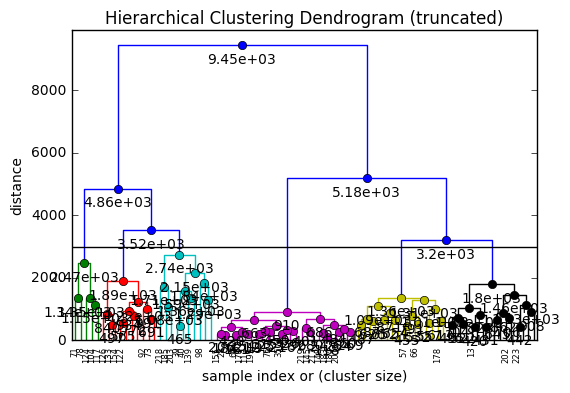

[4 6 4 6 6 4 4 6 5 6 6 4 4 6 4 6 4 4 6 6 6 5 4 4 6 6 6 6 4 4 5 3 6 5 5 4 4
 6 3 3 3 6 6 6 5 6 6 5 4 5 5 6 5 6 4 4 5 5 6 5 4 4 6 6 6 6 5 6 4 5 5 1 5 2
 5 4 6 5 1 6 5 4 4 5 2 3 5 6 4 4 4 5 2 6 2 4 4 6 3 2 6 4 2 2 1 2 3 6 6 6 3
 2 2 4 6 5 6 1 2 3 4 4 2 5 1 5 2 5 6 5 5 3 3 2 6 6 5 3 3 3 6 4 6 5 6 4 6 6
 4 4 5 5 6 5 2 4 4 6 6 6 6 2 5 3 3 5 4 6 5 6 4 4 5 5 6 6 4 4 5 6 6 5 6 4 4
 3 6 6 5 5 4 4 5 6 5 6 4 4 5 4 5 4 6 3 5 3 6 5 6 4 5 5 6 5 5 6 6 4 3 4 4 6
 6 6 5 3 6 4 4 4 4 6 6 4 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1
 1 1 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0]


AttributeError: bins must increase monotonically.

In [10]:
###### import pandas as pd
import numpy as np
import cv2
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import sklearn
from pandas import Series, DataFrame, Panel
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import matplotlib.image as mpimg
from matplotlib import collections as mc 
import os
import matplotlib.ticker as ticker
import collections

import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

##################################### Tunable Variables ###########################################
days_to_process = 7
pd.options.display.max_rows = 10
###################################################################################################

#####################################string variables##############################################
dayArray = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17'
,'18','19','20','21','22','23','24','25','26','27','28','29','30','31']
monthArray = ['01','02','03','04','05','06','07','08','09','10','11','12',]
# Tunable Variables
# currentYear = 2013 # input 1
# pointerMonth = n n1	   # input 2
# pointerDay = 0   # input 3

currentYear = 2012
currentMonth = monthArray[0]
currentDay = dayArray[0]
pointerMonth = 0
pointerDay = 0
daysToChoose = 235 # currently hardcoded, 235 is for entire year of 2012
#####################################################################################################

###############################string concatenation & Load Data########################
counter = 0
frames = pd.DataFrame()
# os.chdir('E:\Documents\MMU Studies\Python Scripts\Track Blobs')
os.chdir('E:\Documents\MMU Studies\Python Scripts\Track LOST dataset')
currentIndex = 1 # This variable is used to reindex every dataframe
print(os.getcwd())
listDay = []
# list season is a list for specifying spring, summer or winter in the visualization
listSeason = []
listDate = []
listDate += [0]
listDate_for_topbottom = []
listDate_for_topbottom += [0]
while counter < daysToChoose:
    stringDate = '001_' + str(currentYear) + str(currentMonth) + str(currentDay) + '.txt' 
    string_to_be_parsed = "pd.read_table('" + stringDate + "',delimiter=' ', header=None, names=col_names)"
    try:
        exec("%s%d = %s" % ("day", counter, string_to_be_parsed))
        tempString_Date = eval("%s%d" % ("day", counter))
        tempString_Date, currentIndex = trackID_reindex(tempString_Date, currentIndex)
        tempList = tempString_Date[['X', 'Y']]
        frames = frames.append(tempString_Date)
        tempFrames = frames[['X', 'Y']]
        listDay += [tempList]
        listSeason += [currentMonth]
        date = str(currentYear) + str(currentMonth) + str(currentDay)
        if counter%6==0:
            listDate += [date]
        if counter%20 == 0:
            listDate_for_topbottom += [date]
        print("Found")
    except:
        print("Not Found")
        counter -= 1
    
    counter += 1
    currentYear, currentMonth, currentDay, pointerMonth, pointerDay = calendarFunction(currentYear, currentMonth, currentDay, pointerMonth, pointerDay)
#######################################################################################
col_names = ['TrackID','FrameNo', 'X', 'Y']
concatDay = frames.sort_values(by='TrackID', ascending=True)
concatDay = concatDay.reset_index(drop=True)
os.chdir('E:\Documents\MMU Studies\Python Scripts')
# np.set_printoptions(threshold=np.nan)
# heatmap_data = constructHeatmap(concatDay)


counter = 0
axis_counter = 0
np_vector_heatmap = []
np_mat = []
np_mat2 = []
np_mat_topbottom = np.empty((48,0)) # 48 is the total number of pools

while counter < daysToChoose:
    heatmap_data = constructHeatmap(listDay[counter])
    vector_heatmap, sum_array, sum_array_top_bottom = heatmapPooling(heatmap_data, 80)
    np_mat += [sum_array]
    np_mat2 += [sum_array_top_bottom]
    np_mat_topbottom = np.insert(np_mat_topbottom, 0, sum_array_top_bottom, axis = 1)
    np_vector_heatmap += [vector_heatmap]
    counter += 1
    axis_counter += 1

np_vector_heatmap = np.asarray(np_vector_heatmap)
# np_mat_transpose = list(map(list, zip(*np_mat))) #cannot transpose cuz it only changes the sides
# print(np_mat_transpose)
# print(max(np_mat[0]))
# print(min(np_mat[0]))
clustered_data = agglomerativeClustering(heatmap_data, np_mat)

# test_transpose_of_topbottom = np_mat_topbottom.transpose()

#2012-1-1 -> 2013-5-18
# print(listDate)
### showing heatmap
# print(listSeason)
# counter_season = 0
# seasons = []
# while counter_season < len(listSeason):
# #     if counter_season % 10 == 0:
#     if listSeason[counter_season] == "12" or listSeason[counter_season] == "01" or listSeason[counter_season] == "02":
#         seasons += ['winter']
#     elif listSeason[counter_season] == "03" or listSeason[counter_season] == "04" or listSeason[counter_season] == "05":
#         seasons += ['spring']
#     elif listSeason[counter_season] == "06" or listSeason[counter_season] == "07" or listSeason[counter_season] == "08":
#         seasons += ['summer']   
#     else:
#         seasons += ['autumn']
#     counter_season += 1


# fig = plt.figure(figsize=(20,20))
# # fig = plt.figure()
# ax = fig.add_subplot(111)
# # heatmap_vector = ax.matshow(np_mat)
# ax.matshow(np_mat)

######################################### Feature vector Visualization ####################################################
# fig2 = plt.figure(figsize=(20,20))
# ax2 = fig2.add_subplot(111)
# ax2.matshow(np_mat)
# # ax2.matshow(np_mat_topbottom_transpose)
# ax2.set_yticklabels(listDate)
# ax2.yaxis.set_major_locator(ticker.MultipleLocator(6))
# # plt.savefig('Heatmap_VEC_2012_with_date.png')

# fig3 = plt.figure(figsize=(20,20))
# ax3 = fig3.add_subplot(111)
# ax3.matshow(np_mat_topbottom)
# # ax3.matshow(np_mat2)
# # ax3.matshow(np_mat)
# ax3.set_xticklabels(listDate_for_topbottom)
# ax3.xaxis.set_major_locator(ticker.MultipleLocator(20))
# # plt.savefig('Heatmap_VEC_2012_with_date_top_bottom.png')
###########################################################################################################################

# plt.show()

In [2]:
def agglomerativeClustering(heatmapArray, feature_vector):
    model_ac = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
    cluster_labels = model_ac.fit_predict(feature_vector)
    params = model_ac.get_params(deep=True)
    linkage_cluster = hierarchy.linkage(feature_vector, 'ward')
    
    plt.title('Agglomerative Clustering On Trajectory Data Pool')
    plt.xlabel('Footsteps Count')
    plt.ylabel('Number of Days')
#     dendrogram = hierarchy.dendrogram(linkage_cluster, p= 5, truncate_mode='level', color_threshold=50, show_leaf_counts=False)
#     dendrogram = hierarchy.dendrogram(linkage_cluster)
    max_d = 3000
    dendrogram = fancy_dendrogram(linkage_cluster, p=6, truncate_mode='level', show_leaf_counts = False, max_d=max_d)
    clusters = hierarchy.fcluster(linkage_cluster, max_d, criterion='distance')
#     plt.savefig('Fancy Dendrogram.png')
    plt.show()
    print((clusters))
    print((cluster_labels))
    
    # create x-axis
    counter_x = 0
    x_axis = []
    feature_axis = []
    feature_axis_counter = collections.Counter(cluster_labels)
    while counter_x < len(feature_axis_counter):
        x_axis += [counter_x]
        feature_axis += [feature_axis_counter[counter_x]]
        counter_x += 1
    
    
    plt.hist(x_axis, feature_axis)
    plt.show()
#     plt.savefig('scatterplot for clustering')
#     plt.show()
#     print(feature_vector)
#     print(cluster_labels)
#     print(params)
    

In [3]:
############# Reference #############
# Original Author: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
#####################################

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = hierarchy.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [4]:
def heatmapPooling(heatmapArray, pooling_dim):
    array_of_pooled_images = []
    yDim = heatmapArray.shape[0]
    xDim = heatmapArray.shape[1]
    pool_i = 0
    start_i = 0
    
    # pooling from top to bottom
    while start_i < yDim:
        pool_j = 0
        start_j = 0
        pool_i += pooling_dim
        while start_j < xDim:
            pool_j += pooling_dim
            pooled_image = heatmapArray[start_i:pool_i, start_j:pool_j]
            array_of_pooled_images += [pooled_image]
            start_j = pool_j
        start_i = pool_i
        
    start_i = 0
    pool_i = 0
    array_of_pooled_images_topbottom = []
    
    # pooling from left to right
    while start_i < xDim:
        pool_j = 0
        start_j = 0
        pool_i += pooling_dim
        while start_j < yDim:
            pool_j += pooling_dim
            pooled_image = heatmapArray[start_j:pool_j, start_i:pool_i]
            array_of_pooled_images_topbottom += [pooled_image]
            start_j = pool_j
#             print(start_j)
        start_i = pool_i
        
    array_of_pooled_images = np.array(array_of_pooled_images)
    array_of_pooled_images_topbottom = np.array(array_of_pooled_images_topbottom)
    vector_array_pooled_images = np.concatenate(array_of_pooled_images)
    vector_array_pooled_images = np.concatenate(vector_array_pooled_images)
    
#     print((array_of_pooled_images))
   
    
#     sum_array = np.sum(array_of_pooled_images)
    rowCounter = 0
#     sum_array = np.empty([array_of_pooled_images.shape[0], 2])
    sum_array = []
    sum_array_top_bottom = []
    
    while rowCounter < array_of_pooled_images.shape[0]:
        sum_of_pool = array_of_pooled_images[rowCounter]
        sum_of_pool_top_bottom = array_of_pooled_images_topbottom[rowCounter]
#         np.set_printoptions(threshold=np.nan)
#         print(array_of_pooled_images[rowCounter].max())
#         print(array_of_pooled_images[rowCounter])
        sum_of_pool = np.sum(sum_of_pool)
        sum_of_pool_top_bottom = np.sum(sum_of_pool_top_bottom)
          # log function
#         sum_of_pool = np.add(sum_of_pool, 1)
#         sum_of_pool = np.log(sum_of_pool)
#         print(sum_of_pool)

#         sum_array = np.insert(sum_array, [rowCounter, 2], [rowCounter+1,sum_of_pool])
        sum_array += [(rowCounter),(sum_of_pool)]
        sum_array_top_bottom += [(rowCounter), (sum_of_pool_top_bottom)]
        rowCounter += 1
#     print("new array")
    sum_array = np.asarray(sum_array)
    sum_array_top_bottom = np.asarray(sum_array_top_bottom)
#     print(sum_array.shape)
    sum_array = np.reshape(sum_array, (int(sum_array.shape[0])/2,2))
    sum_array_top_bottom = np.reshape(sum_array_top_bottom, (int(sum_array_top_bottom.shape[0])/2,2))
    sum_array = np.transpose(sum_array)
    sum_array_top_bottom = np.transpose(sum_array_top_bottom)
    sum_array = sum_array[1]
    sum_array_top_bottom = sum_array_top_bottom[1]
#     sum_array_transpose = sum_array.transpose()
#     print(sum_array_transpose)
    
    return vector_array_pooled_images, sum_array, sum_array_top_bottom

In [5]:
def histogram(heatmapArray):
    plt.figure
    hist_Heatmap = cv2.calcHist([heatmapArray], [3], None, [256], [0, 256])
    plt.plot(hist_Heatmap)
    plt.show()

In [6]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0, 0, 0])

def constructHeatmap(heatmapDataInput): 
    heatmapData = heatmapDataInput[['X','Y']]
    heatmapData = pd.DataFrame.as_matrix(heatmapData)
    heatmapData_X = heatmapDataInput[['X']]
    heatmapData_Y = heatmapDataInput[['Y']]
    heatmapData_X = pd.DataFrame.as_matrix(heatmapData_X)
    heatmapData_X = heatmapData_X.flatten()
    heatmapData_Y = pd.DataFrame.as_matrix(heatmapData_Y)
    heatmapData_Y = heatmapData_Y.flatten()
    
    heatmapData = heatmapData.flatten()

    #insert data for scaling the heatmap
    heatmapData_X = np.insert(heatmapData_X, [0], 0) #Min cap
    heatmapData_X = np.append(heatmapData_X, 640) #Max cap
    heatmapData_Y = np.insert(heatmapData_Y, [0], 0) #Min cap
    heatmapData_Y = np.append(heatmapData_Y, 480) #Max cap
    xmin = 0
    xmax = 640
    ymin = 0
    ymax = 480
    
    ########### hexbin approach ##########
#     %matplotlib notebook
# #     dataHeat = plt.hexbin(heatmapData_X, heatmapData_Y, gridsize=(640,480), xscale='linear', yscale='linear')
#     dataHeat = plt.hexbin(heatmapData_X, heatmapData_Y)
#     plt.axis([xmin, xmax, ymin, ymax])
# #     plt.colorbar()
#     plt.gca().invert_yaxis()
#     plt.savefig('heatmap.png')
    ######################################
    
    ########## try histogram2d approach ############
    dataHistogram = np.histogram2d(heatmapData_X, heatmapData_Y, bins=[640,480])
    ###########################################

    ##################### Overlaying image #########################
#     %matplotlib notebook
#     imageA = cv2.imread("heatmap.png")
#     dim = (640, 480)
#     imageA = cv2.resize(imageA, dim)
#     imageB = cv2.imread("overlayingImage.png")
#     imageC = cv2.add(imageA, imageB)
#     cv2.imshow("heatmap", imageC)
#     cv2.waitKey(0)
    return dataHistogram[0]


In [7]:
def trackID_reindex(dataframe_to_be_reindexed, currentIndex):
    counter = 1
    
    ## Newly indexed Series
    trackID_Series = dataframe_to_be_reindexed[['TrackID']]
    trackID_Series.loc[0].TrackID = currentIndex
    
    ## reference Series
    ref_Series = dataframe_to_be_reindexed[['TrackID']]
    initial_ID = ref_Series.loc[0].TrackID
    
    while counter < len(dataframe_to_be_reindexed):
        if ref_Series.loc[counter].TrackID == initial_ID:
            trackID_Series.loc[counter].TrackID = currentIndex
        else:
            currentIndex += 1
            trackID_Series.loc[counter].TrackID = currentIndex
            initial_ID = ref_Series.loc[counter].TrackID
        counter += 1
    currentIndex += 1 ##for new document
    dataframe_to_be_reindexed[['TrackID']] = trackID_Series    
    return dataframe_to_be_reindexed, currentIndex

In [8]:
def calendarFunction(currentYear, currentMonth, currentDay, pointerMonth, pointerDay):
    if (pointerMonth == 3) or (pointerMonth == 5) or (pointerMonth == 8) or (pointerMonth == 10):
        if currentDay == '30':
            currentDay = dayArray[0]
            pointerMonth += 1
            currentMonth = monthArray[pointerMonth]
            pointerDay = 0
        else:
            pointerDay += 1
            currentDay = dayArray[pointerDay]
            
    elif pointerMonth == 1:
        if (currentYear%4 == 0) and (currentDay == '28'):#leapyear
            pointerDay += 1
            currentDay = dayArray[pointerDay]
        elif (currentYear%4 == 0) and (currentDay == '29'):#reset to 01 if day ends for the month
            currentDay = dayArray[0]
            pointerDay = 0
            pointerMonth += 1
            currentMonth = monthArray[pointerMonth]
        elif (currentYear%4 != 0) and (currentDay == '28'): #Non Leap year
            currentDay = dayArray[0]
            pointerDay = 0
            pointerMonth += 1
            currentMonth = monthArray[pointerMonth]
        else:
            pointerDay += 1
            currentDay = dayArray[pointerDay]
    else: #for 31 days month
        if currentDay == '30':
            pointerDay += 1
            currentDay = dayArray[pointerDay]
        elif currentDay == '31':
            currentDay = dayArray[0]
            pointerDay = 0
            pointerMonth += 1
            currentMonth = monthArray[pointerMonth]
        else:
            pointerDay += 1
            currentDay = dayArray[pointerDay]

    #if year ends?
    if (pointerMonth == 11) and (pointerDay == 30):
        currentYear += 1
        pointerMonth = 0
        pointerDay = 0
        currentMonth = monthArray[pointerMonth]
        currentDay = dayArray[pointerDay]
    return currentYear, currentMonth, currentDay, pointerMonth, pointerDay
    